In [1]:
import numpy as np
import scipy.sparse as sparse
from scipy.io import mmread
from scipy.linalg import expm, norm
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [2]:
# download datasets
dol = mmread('dolphins.mtx').tocsr()
fb = mmread('facebook.mtx').tocsr()
pa = mmread('PA.mtx').tocsr()

In [3]:
# Arnoldi algorithm

# matrix A for which exp(A)b is of interest, n x n
# b initial vector to be used, length n
# m, the produced Krylov subspace will have dimension m

def arnoldi_iteration(A, m: int): 
    b  = np.ones(A.shape[0])  # b default to be 1_n
    
    n = A.shape[0]
    h = np.zeros((m + 1, m)) # to become the m x m upper Hessenberg matrix consisting of the coefficients h_ij
    V = np.zeros((n, m + 1)) # to become the orthonormal basis V_m = [v_1, v_2, ..., v_m]
    v = b / norm(b) # makes v a unit 2-norm vector    
    V[:, 0] = v # use v as the first Krylov vector
    
    for j in range(m):
        w = A @ v  # compute candidate vector
        
        for i in range(j + 1):
            h[i, j] = V[:,i] @ w # h_ij-th element is product of v_i and w
            w = w - h[i, j] * V[:, i] # modified Gram-Schmidt
            
        h[j + 1, j] = norm(w)
        
        zero = 1e-12 # small value used as h_ij = 0 threshold
        if h[j + 1, j] > zero: # if nonzero add v to the basis
            v = w / h[j + 1, j]
            V[:, i + 1] = v
        else: 
            return V, h 
        # print('step',j,'out of',m) # to check how far along algorithm is for larger m
    return V, h

In [4]:
# get Vm and Hm from output
def get_m(Vm1,Hm1,m):
    Vm, Hm = sparse.csc_matrix(Vm1[:,0:m]), sparse.csc_matrix(Hm1[0:m,0:m])
    return Vm, Hm

In [5]:
# get approximation from arnoldi result
def a_approximation(A, Vm, Hm, m):
    # get beta = ||v||_2
    b = np.ones(A.shape[0])
    beta = norm(b)

    # get unit vector
    e1 = np.zeros((m,1))
    e1[0] = 1
    e1 = sparse.csc_matrix(e1)
    
    X = beta * Vm @ expm(Hm) @ e1
    return X

In [6]:
########## TIMINGS

In [7]:
########## DOLPHIN ERROR PLOT

In [8]:
########## PA TIMINGS BAR CHART 

# time runs for 10 20, 30, 40 50 m

In [9]:
Ms = [10, 20, 30, 40, 50, 60]
results = []
timing = []

for m in Ms:
    start = timer()
    for i in range(3):
        paV, paH = arnoldi_iteration(pa, m)
        V, H = get_m(paV,paH,m)
        res = a_approximation(pa, V, H,m)
    end = timer()
    results.append(res)
    timing.append((end - start)/3)


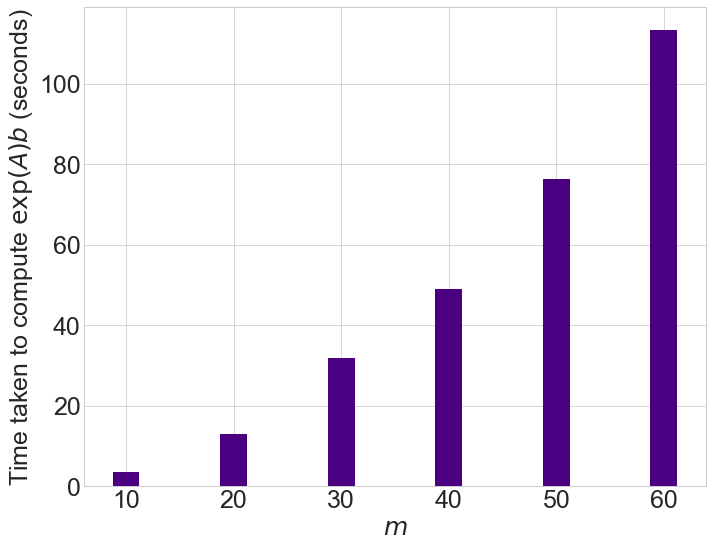

In [33]:
plt.style.use('seaborn-whitegrid') 
n = 25
fig, ax = plt.subplots(figsize = (10,8))
fig = plt.bar(Ms,timing, width = 2.5,color ='indigo')
plt.xlabel(r'$m$', fontsize = n)
plt.ylabel(r'Time taken to compute $\exp(A)b$ (seconds)', fontsize = n)
plt.yticks(fontsize = n)
plt.xticks(fontsize = n)
plt.tight_layout()
plt.savefig('./images/pa_timings.pdf')
plt.show()


In [22]:
# check agreement of central-most nodes
for i in range(len(results)):
    print(results[i].argmax())

847932
847932
847932
847932
847932
847932


In [23]:
# check agreement of least central
for i in range(len(results)):
    print(results[i].argmin())

663
663
663
663
663
663
